In [1]:
import os
# import sys
# os.chdir('..')
# sys.path.append('..')

import yaml
from pathlib import Path


import cv2
import time
import json
import numpy as np
from tqdm import tqdm
from scipy.ndimage import distance_transform_edt, distance_transform_cdt

import torch
import torch.nn.functional as F

from configs.cfgparser import Config
from utils.sdf import SDF

import matplotlib.pyplot as plt
import matplotlib.ticker as tck
# plt.rc('axes', axisbelow=True)
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
with Path("configs/config.yaml").open() as f:
    cfg: dict = yaml.load(f, Loader=yaml.FullLoader)
CONF: Config = Config(cfg)

[INFO] Configuration file passed all validation tests.


In [3]:
def plot_tensor(tsor, labels = False):
    tsor = tsor[0][0].detach().numpy()

    fig, ax = plt.subplots(figsize = (7,7))
    im = ax.imshow(tsor, cmap = 'viridis')

    if labels == True:
        for i in range(tsor.shape[0]):
            for j in range(tsor.shape[0]):
                text = ax.text(j, i, np.round(tsor[i, j],3),
                            ha="center", va="center", color="w")
    

### Kernel size test

In [7]:
# with open(CONF.IDX_FILE) as f:
#     imIDs = f.read().splitlines()

with open(CONF.LBL_JSON) as f:
    lblDict = json.load(f)
    imIDs = lblDict['label_to_id']['2']

speed_arr = []
for k in [3,5,7,9,11,0]:
    t1 = time.time()
    for imID in tqdm(imIDs):
        mask = cv2.imread(f'{CONF.MSK_DIR}/{imID}.png', cv2.IMREAD_GRAYSCALE)
        if k == 0:
            edges = cv2.Canny((255*mask).astype(np.uint8), threshold1=128, threshold2=128)
            sdm_scipy = distance_transform_edt(~edges)
        else:
            mask_tensor = torch.from_numpy(mask).to(torch.float32).unsqueeze(0).unsqueeze(0).to('cuda:0')
            sdm_torch = SDF.sdf(mask_tensor, K=k, imsize=512, distance='chebyshev', normalization='minmax')

    t2 = time.time()
    dt = t2 - t1
    speed_arr.append(dt)

100%|██████████| 929/929 [00:09<00:00, 102.16it/s]


In [107]:
# fig, ax = plt.subplots(figsize=(7,5)) 
# def plot1(yarr, ax):
#     x = [3, 5, 7, 9, 11]
#     y = np.array(yarr[:-1])

#     for gpu in [1,2,4]:
#         ax.scatter(x,y/gpu)
#         ax.plot(x, y/gpu, linestyle='--', linewidth = 0.8, label= f'CDT {gpu} GPUs')

#         for i in range(len(x)):
#             ax.text(x[i] + 0.1, 
#                     y[i]/gpu + 0.5, 
#                     f'{y[i]/gpu:.1f}', fontsize=10)
            
#     ax.axhline(yarr[-1], color = 'r', linestyle = '--', linewidth = 0.8, label = 'EDT SciPy ')
#     ax.text(1.5, yarr[-1] - 3, "{:.1f}".format(yarr[-1]), color="red")
        
#     ax.set_xticks(ticks=x)
#     ax.set_ylim(0,70)
#     ax.set_xlim(2,12)
#     ax.grid(which='both')
#     ax.grid(which='minor', linestyle = '--', alpha=0.5)

#     ax.set_xlabel('kernel size (pixels)')
#     ax.set_ylabel('time (s)')
#     ax.legend()

#     # plt.savefig("fig1.png", format="png", bbox_inches="tight", dpi = 250)

# plot1(speed_arr, ax)

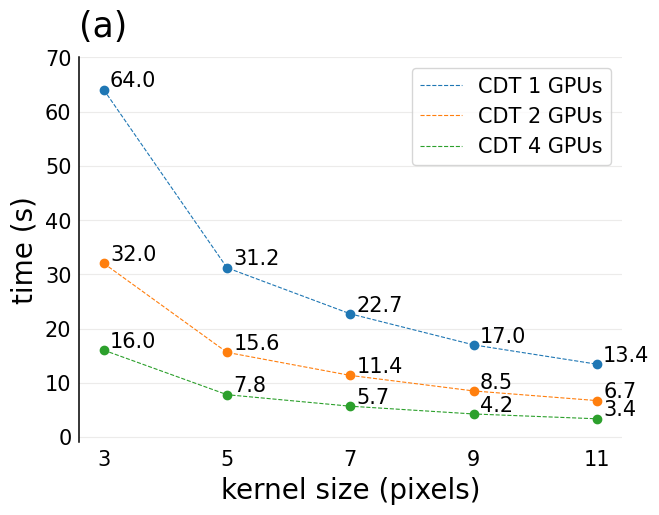

In [23]:
fig, ax = plt.subplots(figsize=(7,5)) 


def plot1(yarr, ax):
    x = [3, 5, 7, 9, 11]
    y = np.array(yarr[:-1])

    for gpu in [1,2,4]:
        ax.scatter(x,y/gpu)
        ax.plot(x, y/gpu, linestyle='--', linewidth = 0.8, label= f'CDT {gpu} GPUs')

        for i in range(len(x)):
            ax.text(x[i] + 0.1, 
                y[i]/gpu + 0.5, 
                f'{y[i]/gpu:.1f}', fontsize=15)
            
    # ax.axhline(speed_arr[-1], color = 'r', linestyle = '--', linewidth = 0.8, label = 'EDT SciPy ', alpha = 0.5)
    # ax.text(1.5, speed_arr[-1] - 3, "{:.1f}".format(speed_arr[-1]), color="red", fontsize=10)

    ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)
    ax.spines[['top','right', 'bottom']].set_visible(False)
    ax.spines['left'].set_linewidth(1.1)

    ax.set_ylim(-1,70)
    ax.set_xticks(ticks=x)
    
    ax.yaxis.set_tick_params(pad=2, bottom=False, labelsize=15)
    ax.xaxis.set_tick_params(pad=2, bottom=False, labelsize=15)

    ax.set_ylabel('time (s)', fontsize=20, labelpad=5) # weight='bold'
    ax.set_xlabel('kernel size (pixels)', fontsize=20, labelpad=5)

    ax.legend(fontsize=15)
    ax.set_title('(a)', loc='left', pad=15, fontsize=25)

plot1(speed_arr, ax)

In [21]:
# fig, ax = plt.subplots(figsize=(7,5)) 

# x = np.array([3, 5, 7, 9, 11])
# y = np.array(speed_arr[:-1])


# plt.bar(x - 0.3, y, width=0.6)
# plt.bar(x, y/2, width=0.6)
# plt.bar(x+0.3, y/4, width=0.6)


# for i in range(len(x)):
#     ax.text(x[i] + 0.1, 
#             y[i] - 0.5, 
#             f'{y[i]:.1f}', fontsize=10)
    
# for i in range(len(x)):
#     ax.text(x[i] + 0.4, 
#             y[i]/2 - 0.1, 
#             f'{y[i]/2:.1f}', fontsize=10)
    
# ax.set_ylim(-1,70)
# # ax.set_xlim(2,11.5)

# ax.set_xticks(ticks=x)

# ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)

# ax.spines[['top','right', 'bottom']].set_visible(False)
# ax.spines['left'].set_linewidth(1.1)

# ax.yaxis.set_tick_params(pad=2, labeltop=False, labelbottom=True, bottom=False, labelsize=10)
# ax.xaxis.set_tick_params(pad=2, labeltop=False, labelbottom=True, bottom=False, labelsize=10)

# ax.set_ylabel('time (s)', fontsize=10, labelpad=5)
# ax.set_xlabel('kernel size (pixels)',fontsize=10, labelpad=5)

# ax.legend()

### Precision test

In [10]:
with open(CONF.LBL_JSON) as f:
    lblDict = json.load(f)
    imIDs = lblDict['label_to_id']['2']

In [11]:
total_mae = []
for imID in tqdm(imIDs):
    img_mae = []
    mask = cv2.imread(f'{CONF.MSK_DIR}/{imID}.png', cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny((255*mask).astype(np.uint8), threshold1=128, threshold2=128)
    
    mask_tensor = torch.tensor(mask).to(torch.float32).unsqueeze(0).unsqueeze(0).to('cuda:0')
    
    sdm_scipy = distance_transform_edt(~edges)
    sdm_scipy = sdm_scipy/sdm_scipy.max()

    for k in [3,5,7,9,11]:
        sdm_torch = SDF.sdf(mask_tensor, K=k, imsize=512, distance='chebyshev', normalization=None)
        sdm_torch = sdm_torch[0][0].detach().cpu().numpy()
        sdm_torch = sdm_torch/sdm_torch.max()

        mae = np.round(np.mean(np.abs(sdm_scipy - sdm_torch)), 3)
        img_mae.append(mae)
    total_mae.append(img_mae)

mae = [np.mean(list(x)) for x in zip(*total_mae)]

100%|██████████| 929/929 [02:44<00:00,  5.64it/s]


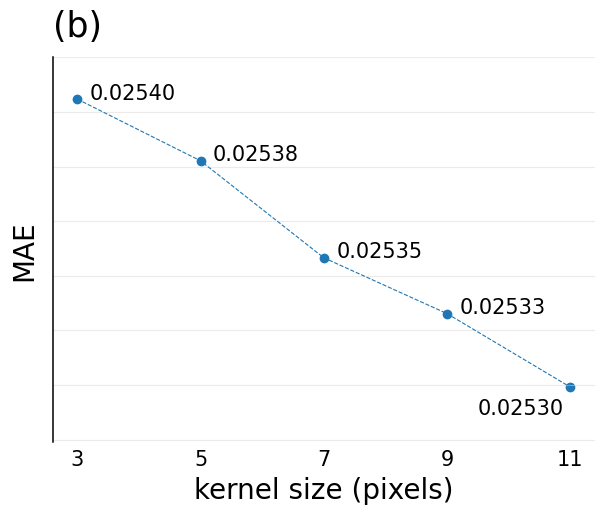

In [26]:
fig, ax = plt.subplots(figsize=(7,5))

def plot2(yarr, ax):
    x = [3, 5, 7, 9, 11]
    y = np.array(yarr)

    ax.scatter(x,y)
    ax.plot(x, y, linestyle='--', linewidth = 0.8)

    for i in range(len(x) - 1):
        ax.text(x[i] + 0.2, 
                y[i], 
                f'{y[i]:.5f}', fontsize=15)
    ax.text(x[4] - 1.5, y[4] - 0.00001, f'{y[4]:.5f}', fontsize=15)


    ax.set_ylim(.025279,.02542)

    ax.set_xticks(ticks=x)
    ax.set_yticklabels([])

    ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)

    ax.spines[['top','right', 'bottom']].set_visible(False)
    ax.spines['left'].set_linewidth(1.1)

    ax.yaxis.set_tick_params(pad=2, bottom=False, labelsize=15)
    ax.xaxis.set_tick_params(pad=2, bottom=False, labelsize=15)

    ax.set_ylabel('MAE', fontsize=20, labelpad=5)
    ax.set_xlabel('kernel size (pixels)',fontsize=20, labelpad=5)
    ax.set_title('(b)', loc = 'left', pad = 15, fontsize = 25)

plot2(mae, ax)

100%|██████████| 10/10 [00:00<00:00, 14.69it/s]


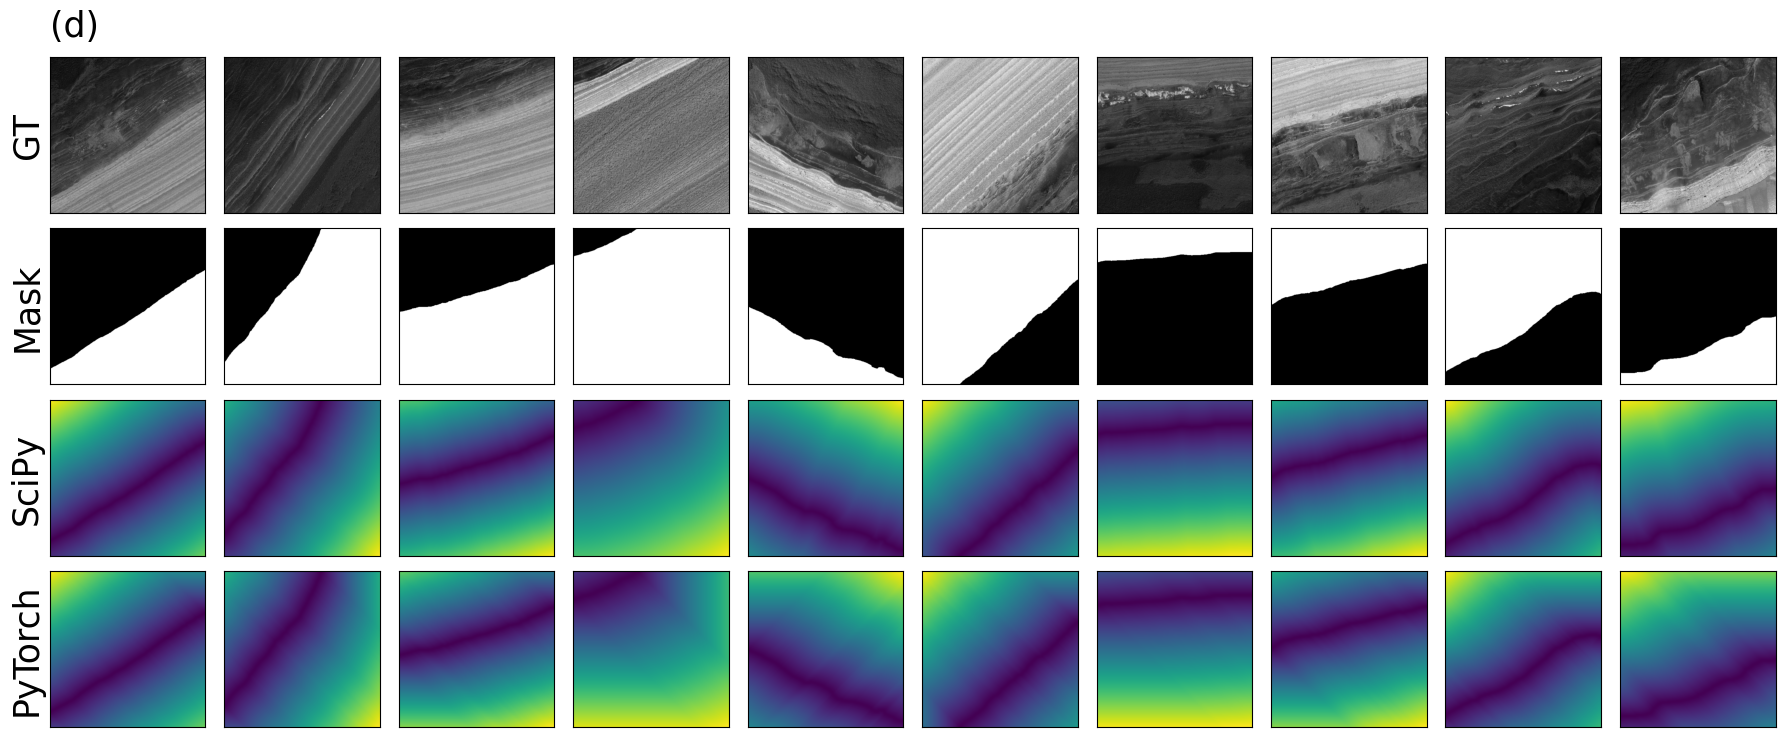

In [32]:
num_imgs = 10
fig, ax = plt.subplots(4, num_imgs, figsize=(18,7))

def plot4(fig, ax):
    with open(CONF.LBL_JSON) as f:
        lblDict = json.load(f)
        imIDs = lblDict['label_to_id']['2']

    imIDs = np.random.choice(imIDs, num_imgs)
    for i,imID in enumerate(tqdm(imIDs)):
        mask = cv2.imread(f'{CONF.MSK_DIR}/{imID}.png', cv2.IMREAD_GRAYSCALE)
        img = cv2.imread(f'{CONF.IMG_DIR}/{imID}.png', cv2.IMREAD_GRAYSCALE)/255
        edges = cv2.Canny((255*mask).astype(np.uint8), threshold1=128, threshold2=128)
        
        mask_tensor = torch.tensor(mask).to(torch.float32).unsqueeze(0).unsqueeze(0).to('cuda:0')
        
        sdm_scipy = distance_transform_edt(~edges)
        sdm_scipy = sdm_scipy/sdm_scipy.max()

        sdm_torch = SDF.sdf(mask_tensor, K = 7, normalization = None)
        sdm_torch = sdm_torch[0][0].detach().cpu().numpy()
        sdm_torch = sdm_torch/sdm_torch.max()

        ax1, ax2, ax3, ax4 = ax[0], ax[1], ax[2], ax[3]

        ax1[i].imshow(img, cmap = 'gray')
        ax1[i].set_xticks([])
        ax1[i].set_yticks([])

        ax2[i].imshow(mask, cmap = 'gray')
        ax2[i].set_xticks([])
        ax2[i].set_yticks([])

        ax3[i].imshow(sdm_scipy, cmap = 'viridis')
        ax3[i].set_xticks([])
        ax3[i].set_yticks([])
        
        ax4[i].imshow(sdm_torch, cmap = 'viridis')
        ax4[i].set_xticks([])
        ax4[i].set_yticks([])
        

    ax1[0].set_ylabel('GT', fontsize = 25)
    ax2[0].set_ylabel('Mask', fontsize = 25)
    ax3[0].set_ylabel('SciPy', fontsize = 25)
    ax4[0].set_ylabel('PyTorch', fontsize = 25)

    fig.tight_layout()
    fig.subplots_adjust(hspace=0.1)
    ax1[0].set_title('(d)', loc = 'left', pad = 15, fontsize = 25)
    plt.savefig("fig2.png", format="png", bbox_inches="tight", dpi = 250)

plot4(fig, ax)

### Speed Test

In [31]:
speed_arr2 = []
with open(CONF.LBL_JSON) as f:
    lblDict = json.load(f)
    imIDs = lblDict['label_to_id']['2']

In [32]:
# SciPy
t1 = time.time()
for imID in tqdm(imIDs):
    mask = cv2.imread(f'{CONF.MSK_DIR}/{imID}.png', cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny((255*mask).astype(np.uint8), threshold1=128, threshold2=128)
    sdm_scipy = distance_transform_edt(~edges)

t2 = time.time()
dt = t2 - t1
speed_arr2.append(np.round(dt, 2))
print(f'SciPy EDT: {dt}s')

100%|██████████| 929/929 [00:09<00:00, 101.82it/s]

SciPy EDT: 9.125633716583252s


In [35]:
# PyTorch CPU
t1 = time.time()

for imID in tqdm(imIDs):
    mask = cv2.imread(f'{CONF.MSK_DIR}/{imID}.png', cv2.IMREAD_GRAYSCALE)
    mask_tensor = torch.from_numpy(mask).to(torch.float32).unsqueeze(0).unsqueeze(0)
    sdm_torch = SDF.sdf(mask_tensor, K = 7)

t2 = time.time()
dt = t2 - t1
speed_arr2.append(np.round(dt, 2))
print(f'PyTorch CPU: {dt}s')

100%|██████████| 929/929 [03:22<00:00,  4.59it/s]

PyTorch CPU: 202.26064133644104s


In [36]:
# PyTorch CPU batched
t1 = time.time()

mask_batch = []
imID_batch = []
for i, imID in enumerate(tqdm(imIDs), start=1):
    mask = cv2.imread(f'{CONF.MSK_DIR}/{imID}.png', cv2.IMREAD_GRAYSCALE)
    mask_batch.append(mask) 
    imID_batch.append(imID)
    if i%16 == 0 or i == len(imIDs):
        mask_batch = np.stack(mask_batch, axis=0)
        mask_batch_tensor = torch.from_numpy(mask_batch).to(torch.float32).unsqueeze(1)

        SDMs = SDF.sdf(mask_batch_tensor, K = 7)

        mask_batch = []
        imID_batch = []

t2 = time.time()
dt = t2 - t1
speed_arr2.append(np.round(dt, 2))
print(f'PyTorch CPU batched: {dt}s')

100%|██████████| 929/929 [02:30<00:00,  6.16it/s]

PyTorch CPU batched: 150.92854475975037s


In [37]:
# PyTorch GPU
t1 = time.time()

for imID in tqdm(imIDs):
    mask = cv2.imread(f'{CONF.MSK_DIR}/{imID}.png', cv2.IMREAD_GRAYSCALE)
    mask_tensor = torch.from_numpy(mask).to(torch.float32).unsqueeze(0).unsqueeze(0).to('cuda:0')
    sdm_torch = SDF.sdf(mask_tensor, K = 7)

t2 = time.time()
dt = t2 - t1
speed_arr2.append(np.round(dt, 2))
print(f'PyTorch GPU: {dt}s')

100%|██████████| 929/929 [00:22<00:00, 40.95it/s]

PyTorch GPU: 22.684881925582886s


In [38]:
# PyTorch GPU batched
t1 = time.time()
mask_batch = []
imID_batch = []

for i, imID in enumerate(tqdm(imIDs), start=1):
    mask = cv2.imread(f'{CONF.MSK_DIR}/{imID}.png', cv2.IMREAD_GRAYSCALE)
    mask_batch.append(mask) 
    imID_batch.append(imID)
    if i%16 == 0 or i == len(imIDs):
        mask_batch = np.stack(mask_batch, axis=0)
        mask_batch_tensor = torch.from_numpy(mask_batch).to(torch.float32).unsqueeze(1)
        mask_batch_tensor = mask_batch_tensor.to('cuda:0')

        SDMs = SDF.sdf(mask_batch_tensor, K = 7)

        mask_batch = []
        imID_batch = []
t2 = time.time()
dt = t2 - t1
speed_arr2.append(np.round(dt, 2))
print(f'PyTorch GPU batch: {dt}s')

100%|██████████| 929/929 [00:05<00:00, 179.58it/s]

PyTorch GPU batch: 5.173779487609863s


In [39]:
speed_arr2.append(np.round(speed_arr2[-1]/4, 1))

In [41]:
speed_arr2

[9.13, 199.05, 202.26, 150.93, 22.68, 5.17, 1.3]

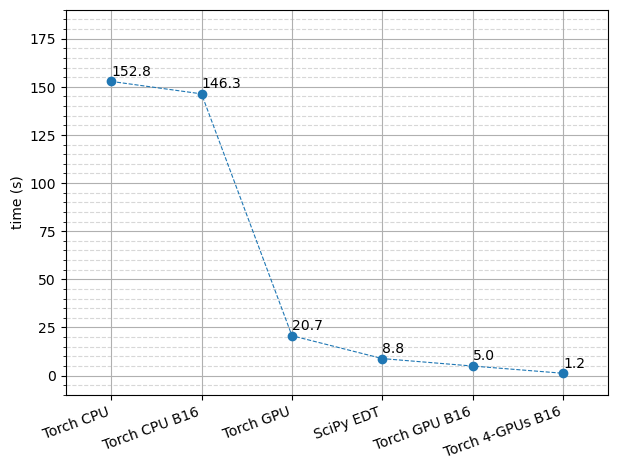

In [103]:
fig, ax = plt.subplots(figsize=(7,5))

def plot3(ax):
    x = ['Torch CPU', 'Torch CPU B16', 'Torch GPU', 'SciPy EDT', 'Torch GPU B16', 'Torch 4-GPUs B16']
    x_i = [0,1,2,3,4,5]
    y = [152.83, 146.35, 20.72, 8.83, 4.95, 1.2]

    ax.scatter(x,y)
    ax.plot(x, y, linestyle='--', linewidth = 0.8)
    plt.xticks(rotation=20, ha='right')

    for i in range(len(x)):
        ax.text(x_i[i], y[i] + 3, f'{y[i]:.1f}', fontsize=10)
        

    ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
    ax.set_xlim(-0.5,5.5)
    ax.set_ylim(-10,190)

    ax.grid(which='both')
    ax.grid(which='minor',linestyle = '--', alpha=0.5)
    ax.set_ylabel('time (s)')

plot3(ax)

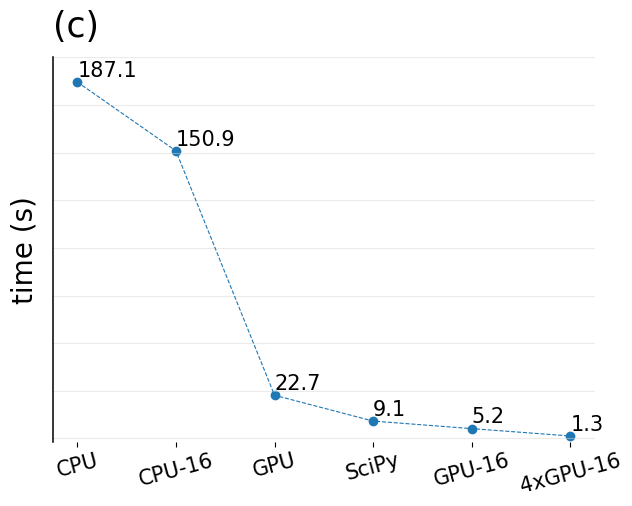

In [28]:
fig, ax = plt.subplots(figsize=(7,5))

def plot3(ax):
    x = ['CPU', 'CPU-16', 'GPU', 'SciPy', 'GPU-16', '4xGPU-16']
    x_i = [0,1,2,3,4,5]
    # y = [152.83, 146.35, 20.72, 8.83, 4.95, 1.2]
    y = [187.05, 150.93, 22.68, 9.13, 5.17, 1.3]

    ax.scatter(x,y)
    ax.plot(x, y, linestyle='--', linewidth = 0.8)

    for i in range(len(x)):
        ax.text(x_i[i], y[i] + 3, f'{y[i]:.1f}', fontsize=15)

    ax.set_ylim(-2,200)
    # ax.set_xlim(2,12)
    ax.set_yticklabels([])

    ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)

    ax.spines[['top','right', 'bottom']].set_visible(False)
    ax.spines['left'].set_linewidth(1.1)

    ax.yaxis.set_tick_params(pad=2, labeltop=False, labelbottom=True, bottom=False, labelsize=15)
    ax.xaxis.set_tick_params(pad=2, labelsize=15, labelrotation=15)

    ax.set_ylabel('time (s)', fontsize=20, labelpad=5)
 
    ax.set_title('(c)', loc = 'left', pad = 15, fontsize = 25)

plot3(ax)

In [185]:
165/7

23.571428571428573

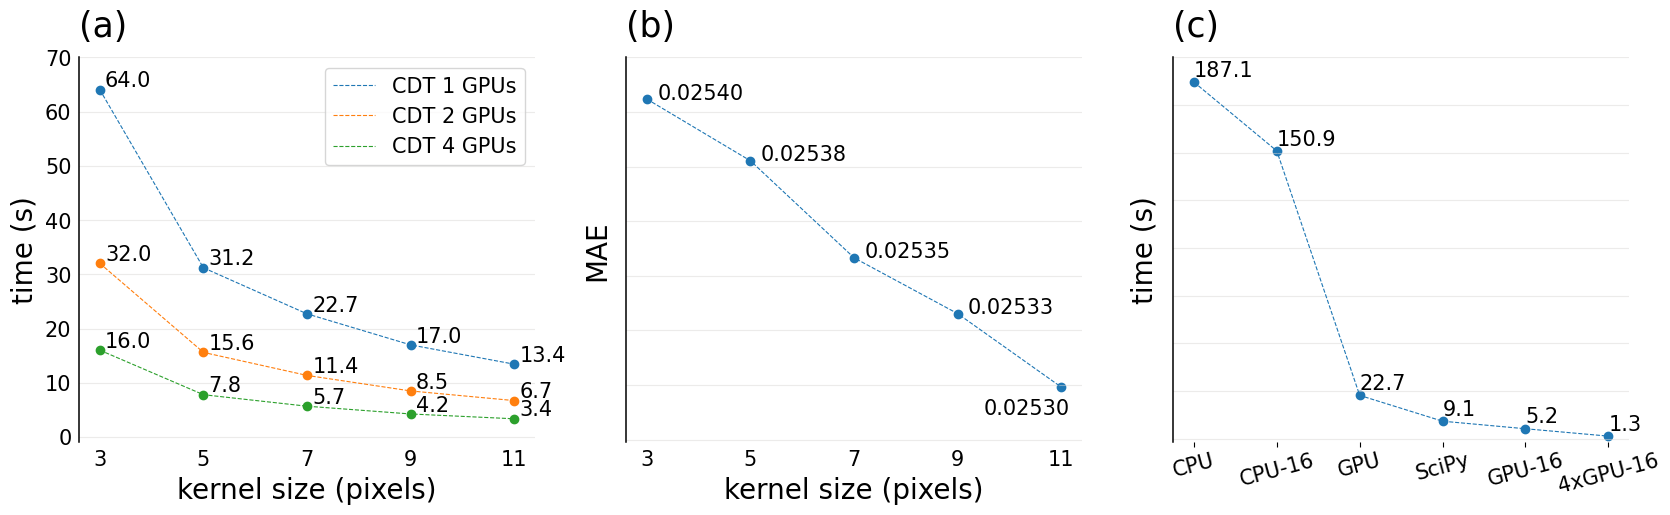

In [30]:
fig, ax = plt.subplots(1,3, figsize=(20,5))
plot1(speed_arr, ax[0])
plot2(mae, ax[1])
plot3(ax[2])

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2)
# plot4([ax[3], ax[4], ax[5], ax[6]])
# plt.savefig('fig1.png')
plt.savefig("fig1.png", format="png", bbox_inches="tight", dpi = 250)

In [1]:
import os
import sys
os.chdir('..')
sys.path.append('..')

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import cv2 
import math
import json
import numpy as np
from tqdm import tqdm
from pathlib import Path
from scipy.ndimage import distance_transform_cdt
from scipy.ndimage import distance_transform_edt
from utils.sdf import SDF

import torch
import torch.nn.functional as F

from configs.config_parser import CONF

import matplotlib.pyplot as plt

[INFO] Configuration file configs\config.yaml passed all validation tests.


In [2]:
device = 'cuda:0'

with CONF.LBL_JSON.open() as f:
    lblDict = json.load(f)
    imIDs = lblDict['boundary']

mask_batch, imID_batch = [], []
for i, imID in enumerate(tqdm(imIDs, desc=f'[PROC] Generating SDMs on {device}'), start=1):
    mask_path = str(CONF.MSK_DIR / f'{imID}.png')
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    break

[PROC] Generating SDMs on cuda:0:   0%|          | 0/929 [00:00<?, ?it/s]


In [3]:
mask = torch.tensor(mask/255).float().unsqueeze(0).unsqueeze(0).to(device)

In [16]:
sdm = SDF.sdf(mask)
sdm = SDF._normalize_sdm(sdm, mask, normalization = 'static_max')
sdm = sdm.detach().cpu().numpy()[0][0]

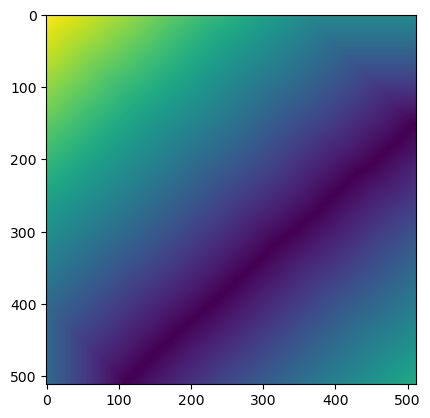

In [17]:
plt.imshow(np.abs(sdm), cmap='viridis')

In [15]:
# sdm_8bit_img = (255 * sdm / sdm.max()).astype(np.uint8)

sdm_8bit_img = np.abs(255*sdm).astype(np.uint8)
colormap = cv2.applyColorMap(sdm_8bit_img, cv2.COLORMAP_VIRIDIS)
cv2.imwrite('sdm_test.png', colormap)

True

In [9]:
sdm_8bit_img

array([[  1,   2,   2, ..., 135, 135, 135],
       [  2,   2,   2, ..., 135, 135, 135],
       [  2,   3,   3, ..., 136, 136, 136],
       ...,
       [169, 170, 171, ..., 252, 253, 253],
       [169, 170, 171, ..., 253, 253, 254],
       [169, 170, 171, ..., 254, 254, 255]], dtype=uint8)